## Skoltech
## Intro to data science, fall 2020
## Assigment 2

### Goals
- Make exploratory data analysis
- Apply feature engineering and feature selection
- Try to solve classification task and use classification performance metrics
- Get the taste of gradient boosting approach

#### Import basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

### Dataset
For the task we'll use kickstarter dataset. Kickstarter is the crowdfounding platform, where people can announce their project with financial goals and other can support the projects by paying the money ("pledging"). The goal will be to predict if the project will be successfull, i.e. would it achieve the funding goal. Let's take a brief look to the dataset.

In [2]:
df = pd.read_csv('ks-projects-201801.csv')
df.set_index("ID", inplace=True)

In [3]:
df.sample(5)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
103477745,"Tasseomancy's In a Glass, Darkly",Country & Folk,Music,USD,2011-03-12,3000.0,2011-02-10 22:49:20,3457.77,successful,77,US,3457.77,3457.77,3000.0
2069623198,Golf Learning Tool- Wave & Shake Golf Glove- E...,Live Games,Games,USD,2016-04-29,500.0,2016-02-29 18:02:25,19.00,failed,2,US,19.00,19.00,500.0
1599141658,Perfection Is Possible,Film & Video,Film & Video,USD,2017-09-04,2500.0,2017-07-06 12:58:59,33.00,failed,2,US,0.00,33.00,2500.0
940970410,AMEN BROTHER,Country & Folk,Music,USD,2012-07-09,5000.0,2012-06-05 05:46:01,5355.00,successful,87,US,5355.00,5355.00,5000.0
516577616,Gamemaster Howard's Know-It-All,Video Games,Games,USD,2012-10-24,50000.0,2012-09-24 22:58:29,17892.50,failed,477,US,17892.50,17892.50,50000.0


In [4]:
df.shape

(378661, 14)

In [5]:
df.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

# Section 1. Dataset acquaintance

-----

### Q1.1

#### How many NaN values are there in the dataset?

----

In [6]:
df.count()

name                378657
category            378661
main_category       378661
currency            378661
deadline            378661
goal                378661
launched            378661
pledged             378661
state               378661
backers             378661
country             378661
usd pledged         374864
usd_pledged_real    378661
usd_goal_real       378661
dtype: int64

In [7]:
df.isna().sum().sum()

3801

In [8]:
df.dropna(inplace=True)

----

Let us simplify the task a little bit: we are aiming to predict either project fails or not.
Thus 'success' projects will be encoded as 1, with state ['failed', 'canceled'] as 0 and we remove the rows with any other state.

### Q1.2 
#### How many '1' values are in resulting dataset (in state column)?

-----

In [9]:
df.state.value_counts()

failed        197611
successful    133851
canceled       38757
live            2798
suspended       1843
Name: state, dtype: int64

In [10]:
df = df[(df.state == 'failed') | (df.state == 'successful') | (df.state == 'canceled')]

In [11]:
df.state.value_counts()

failed        197611
successful    133851
canceled       38757
Name: state, dtype: int64

In [12]:
df['state'] = (df.state == 'successful').astype('int')

In [13]:
df.sample(3)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1331885922,My Life Sucks: The Animated Series,Animation,Film & Video,USD,2015-07-31,30000.0,2015-07-01 07:29:18,10.0,0,1,US,10.00,10.00,30000.00
814366892,Zombie Cats,Playing Cards,Games,AUD,2015-05-07,7000.0,2015-04-07 10:47:30,197.0,0,7,AU,150.04,155.88,5538.85
457783525,Vengeful Ghost: The First Year,Comics,Comics,USD,2017-04-06,1850.0,2017-03-04 13:53:02,2510.0,1,99,US,299.00,2510.00,1850.00


In [14]:
print(df.state.value_counts()[1])


133851


In [15]:
df2 = df.copy()

------

### Q1.3
#### Whats is a name of a project attracted the biggest pay check? (on average). Use column usd_pledged_real to judge. If there are multiple projects, choose any single one.

-----

In [16]:
av_chk = df.apply(lambda x: 0 if x['backers']==0 else x['usd_pledged_real'] / x['backers'], axis=1)

In [17]:
df[av_chk == av_chk.value_counts().sort_index(ascending=False).index[0]]['name']

ID
1459482568                   Patented (9 seasons) food enhancer
1767293256                                  KIRISUTOS PACHYDERM
1974395971    21st CENTURY MEDICAL PRACTICE SYSTEM THAT CHAN...
2024799289                                The Commoner Princess
281085395     "SUNBURN" - starring Michael Madsen, indie act...
472233286     Hollow Earth Project, Journey to the center of...
642968820                          Nobody: The Movie (Canceled)
889803741           Post Traumatic Stress (PTSD) Affects Us All
912587650              The Hare On The Chair - An Easter Legend
Name: name, dtype: object

-----

### Q1.4
#### What is the most successful main category (in terms of success percentage)?

-----

In [18]:
df['main_category'].value_counts()

Film & Video    62247
Music           49101
Publishing      39014
Games           34719
Technology      31761
Design          29515
Art             27862
Food            24263
Fashion         22424
Theater         10850
Comics          10720
Photography     10675
Crafts           8661
Journalism       4671
Dance            3736
Name: main_category, dtype: int64

In [19]:
gp = df.groupby('main_category').state.mean().sort_values(ascending=False)

In [20]:
gp.index[0]

'Dance'

-----

### Q1.5
#### Define the category with highest goal per project. How many projects belong to it?  (note: we use category here, not main_category)

-----

In [21]:
df['category'].value_counts()

Product Design     21886
Documentary        16065
Tabletop Games     14036
Music              13208
Shorts             12303
                   ...  
Residencies           69
Letterpress           47
Chiptune              35
Literary Spaces       23
Taxidermy             11
Name: category, Length: 159, dtype: int64

In [22]:
df[df.category == (df.groupby('category')['goal'].sum() / df['category'].value_counts()).idxmax()].shape[0] #227

227

-----

### Q1.6
#### What is the category with biggest total pledge? Use 'usd_pledged_real' to judge.

------

In [23]:
gp = (df.groupby('category').usd_pledged_real.sum()).sort_values(ascending=False)

In [24]:
gp.index[0]

'Product Design'

------

As one can notice, there are both numerical and object-type data in our dataframe. 

We suggest you to split them to perform EDA separately. 

### Q1.7
#### Split columns to 'numeric' (by data type) and object-type. How many 'object-type' features are there?

In [25]:
df.dtypes

name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                 int32
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [26]:
numeric_columns = df.select_dtypes(include='number').columns
object_columns = df.select_dtypes(include="object").columns
len(object_columns)

7

### Q1.8
#### Let's do a bit of feature engineering. Let's create column 'pledge2goal' which define as ratio of usd_pledged_real to goal. How many outliers are there?
#### (We use a simple rule: an object is an outlier if it does not belong to [q25 - 1.5iqr, q75 + 1.5 iqr] interval, where qxx -- xx quantile, and iqr is inter-quantile range.)

In [27]:
l = df.shape[0]

In [28]:
df['pledged/goal'] = df.apply(lambda row: 0 if row['goal'] == 0 else row['usd_pledged_real']/row['goal'], axis=1)
q25, q75 = df['pledged/goal'].quantile([.25, .75])
iqr = q75 - q25

In [29]:
df = df[df['pledged/goal'].between(q25-1.5*iqr, q75+1.5*iqr)]

In [30]:
l - df.shape[0] 

18415

### Q1.9
#### Visualize the feature for success and fail cases. What can you say about received distributions? (use bins=10 or 20). Type letter as your answer
- A. Distributions intersect significantly, hard to say for sure that the ratio matters.
- B. Distributions have almost no intersection, the bigger ratio, the bigger success.
- C. Distributions intersect significantly, the bigger ratio, the bigger success
- D. Distributions have almost no intersection, the less ratio, the bigger success.

-----

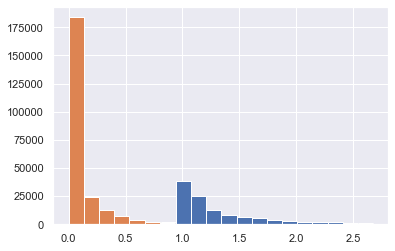

In [31]:
plt.hist(df[df['state'] == 1]['pledged/goal'], bins=20)
plt.hist(df[df['state'] == 0]['pledged/goal'], bins=20)
plt.show()


Answer: B

-----

### Q1.10
#### Continue with plot from Q1.9. Where are the peaks located? We expect two numbers here as the answer

-----

In [32]:
# 0, 1

In [33]:
df['pledged/goal'].value_counts()


0.000000    50647
1.000000     3298
0.010000     1567
0.001000     1391
0.002000     1319
            ...  
1.416305        1
0.000002        1
0.149271        1
0.113103        1
1.423867        1
Name: pledged/goal, Length: 142409, dtype: int64

-----

### Q1.11
#### Compute Pearson correlation coefficient between the pledge2goal and target variable.

----

In [34]:
np.round(df['pledged/goal'].corr(df['state']), 3)

0.902

-----

### Q1.12
#### Visualize dependancy of numerical data with success. What can you say about it?

In [35]:
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore", category=UserWarning)

c:\users\denis\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
c:\users\denis\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
c:\users\denis\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
c:\users\denis\appdata\local\programs\python\python36\lib\site-pa

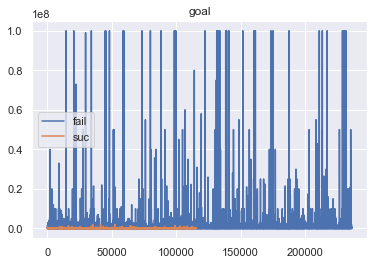

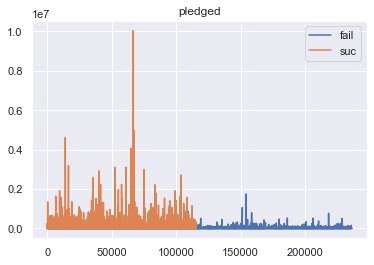

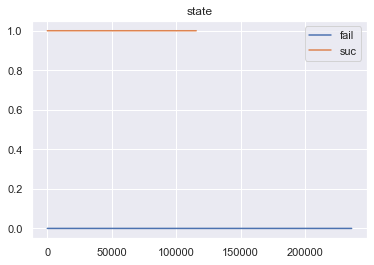

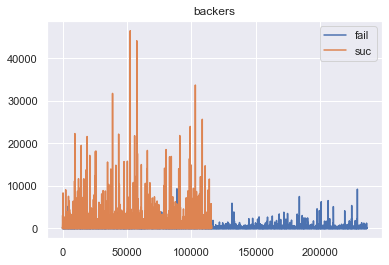

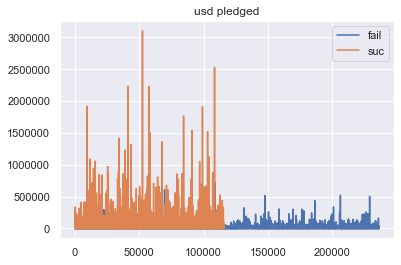

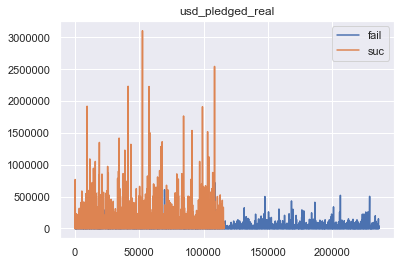

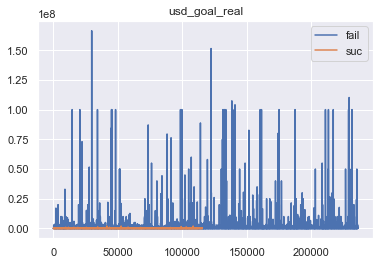

In [36]:
for col in numeric_columns:
    plt.plot( np.arange(df[df['state'] == 0].shape[0]), df[df['state'] == 0][col], label='fail');
    plt.plot( np.arange(df[df['state'] == 1].shape[0]), df[df['state'] == 1][col], label='suc');#plt.hist(df[df['target'] == 1][col], bins=10, label='success')
    plt.title(col)
    plt.legend()
    plt.show()

### Description

- goal - projects with high goal have less success
- pledged - projects with higher pledged have higher success
- backers - projects with highest number of backers have higher success
- usd pledged ~ pledged
- usd pledged real  ~ pledged
- usd goal real ~ goal
- target - useless



# Feature generation
Lets' generate some more feature that could be useful

In [37]:
df = df2.copy()

### Q2.1 Create a year column that would hold the year. How many projects were in year 2012?

In [38]:
df['year'] = pd.to_datetime(df.launched).dt.year

In [39]:
df.head(5)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,year
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,2015
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,2017
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,2013
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,2012
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,US,1283.0,1283.0,19500.00,2015


In [40]:
df[df.year==2012].shape[0]

41109

### Q2.2 Make a column 'duration_days' with number of full days from launch to deadline.
What is median value for this column?

In [41]:
df['duration_days'] = (pd.to_datetime(df.deadline) - pd.to_datetime(df.launched)).dt.days

In [42]:
df.head(5)

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,year,duration_days
ID,,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,2015,58
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,2017,59
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,2013,44
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,2012,29
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,US,1283.0,1283.0,19500.00,2015,55


In [43]:
df.duration_days.median()

29.0

### Q2.3 Delete mistaken value from column 'country'. What is the value?

In [44]:
df.country.value_counts()

US    289669
GB     33214
CA     14508
AU      7681
DE      4057
FR      2873
NL      2807
IT      2775
ES      2204
SE      1718
MX      1632
NZ      1425
DK      1083
IE       793
CH       736
NO       694
BE       597
AT       576
HK       564
SG       521
LU        61
JP        31
Name: country, dtype: int64

In [45]:
df = df[df.country != 'N,0"']

In [46]:
df.country.value_counts()

US    289669
GB     33214
CA     14508
AU      7681
DE      4057
FR      2873
NL      2807
IT      2775
ES      2204
SE      1718
MX      1632
NZ      1425
DK      1083
IE       793
CH       736
NO       694
BE       597
AT       576
HK       564
SG       521
LU        61
JP        31
Name: country, dtype: int64

### Q2.4 Make column 'region' out of column country (america, europe, asia, oceania(including australiza/nz))
Where is the region with the worst conversion rate (percentage of successful projects)

In [47]:
america = ['US', 'CA', 'MX']
europe = ['GB', 'DE', 'FR', 'NL', 'IT', 'ES', 'SE', 'DK', 'IE', 'CH', 'NO', 'BE', 'AT', 'LU']
asia = ['HK', 'SG', 'JP']
oceania = ['AU', 'NZ']

def region(x):
    if x in america:
        return 'america'
    elif x in europe:
        return 'europe'
    elif x in asia:
        return 'asia'
    elif x in oceania:
        return 'oceania'

df['region'] = df['country'].apply(region)

In [48]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,year,duration_days,region
ID,,,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,2015,58,europe
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,2017,59,america
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,2013,44,america
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,2012,29,america
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,US,1283.0,1283.0,19500.00,2015,55,america


In [49]:
gp = df.groupby('region').state.mean().sort_values(ascending=True)

In [50]:
gp.index[0]

'oceania'

### Q2.5 For each main_category leave only the three most popular category and replace other with "other"
What is the most frequent subcategory for design?

In [51]:
gp = df.groupby('main_category')['category'].value_counts()


In [52]:
gp.index

MultiIndex([(       'Art',               'Art'),
            (       'Art',          'Painting'),
            (       'Art',      'Illustration'),
            (       'Art',        'Public Art'),
            (       'Art',       'Mixed Media'),
            (       'Art',   'Performance Art'),
            (       'Art',         'Sculpture'),
            (       'Art',       'Digital Art'),
            (       'Art',    'Conceptual Art'),
            (       'Art',     'Installations'),
            ...
            ('Technology', 'Fabrication Tools'),
            ('Technology',       'Makerspaces'),
            (   'Theater',           'Theater'),
            (   'Theater',             'Plays'),
            (   'Theater',           'Musical'),
            (   'Theater',         'Festivals'),
            (   'Theater',      'Experimental'),
            (   'Theater',         'Immersive'),
            (   'Theater',            'Spaces'),
            (   'Theater',            'Comedy')],
   

In [53]:
mc = df.main_category.unique()
top_3_cat = {}

for cat in mc:
    bot = gp.loc[cat][:3].index.to_numpy()
    top_3_cat[cat] = bot

In [54]:
df['category'] = df.apply(lambda x: x['category'] if (x['category'] in top_3_cat[x['main_category']]) else 'other', axis=1)

In [55]:
gp = df.groupby('main_category')['category'].value_counts()

In [56]:
gp.index

MultiIndex([(         'Art',            'other'),
            (         'Art',              'Art'),
            (         'Art',         'Painting'),
            (         'Art',     'Illustration'),
            (      'Comics',           'Comics'),
            (      'Comics',      'Comic Books'),
            (      'Comics',   'Graphic Novels'),
            (      'Comics',            'other'),
            (      'Crafts',           'Crafts'),
            (      'Crafts',            'other'),
            (      'Crafts',      'Woodworking'),
            (      'Crafts',              'DIY'),
            (       'Dance',            'Dance'),
            (       'Dance',     'Performances'),
            (       'Dance',            'other'),
            (       'Dance',           'Spaces'),
            (      'Design',   'Product Design'),
            (      'Design',           'Design'),
            (      'Design',   'Graphic Design'),
            (      'Design',            'other'),


In [57]:
df['category'].nunique()

45

In [58]:
gp.loc['Design'].index[0]

'Product Design'

### Q2.6 create the columns "name_length" with length of the name.
What is the biggets length?

In [59]:
df['name_length'] = df['name'].apply(lambda x: len(str(x)))

In [60]:
df['name_length'].max()

96

# Preprocessing

In [61]:
df2 = df.copy()

### Q3.1 Drop the leaking columns
Based on what we have already seen, can you assume what features are leakeges? What is the columns? Drop them


In [62]:
df = df2.copy()

In [63]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,year,duration_days,region,name_length
ID,,,,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,other,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,2015,58,europe,31
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,other,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,2017,59,america,45
1000004038,Where is Hank?,other,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,2013,44,america,14
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,2012,29,america,49
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,US,1283.0,1283.0,19500.00,2015,55,america,58


In [64]:
df.columns

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'year', 'duration_days', 'region',
       'name_length'],
      dtype='object')

In [65]:
useless_features = sorted(['deadline', 'launched', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'])

In [66]:
useless_features

['backers',
 'deadline',
 'launched',
 'pledged',
 'usd pledged',
 'usd_pledged_real']

In [67]:
for col in useless_features:
    df.drop(col, axis=1, inplace=True)

In [68]:
df.head()

,name,category,main_category,currency,goal,state,country,usd_goal_real,year,duration_days,region,name_length
ID,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,other,Publishing,GBP,1000.0,0,GB,1533.95,2015,58,europe,31
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,other,Film & Video,USD,30000.0,0,US,30000.00,2017,59,america,45
1000004038,Where is Hank?,other,Film & Video,USD,45000.0,0,US,45000.00,2013,44,america,14
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,5000.0,0,US,5000.00,2012,29,america,49
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,19500.0,0,US,19500.00,2015,55,america,58


### Q3.2 Deal with the categorical features.
Lets drop some more columns for now (name, deadline, launched, country, usd_goal_real). Note: you can re-use these columns in the Q5 section. 
Preprocess the rest of categorical columns. How many columns do you have now?

In [69]:
df.drop('name', axis=1, inplace=True)
df.drop('country', axis=1, inplace=True)
df.drop('usd_goal_real', axis=1, inplace=True)

In [70]:
df.head()

,category,main_category,currency,goal,state,year,duration_days,region,name_length
ID,,,,,,,,,
1000002330,other,Publishing,GBP,1000.0,0,2015,58,europe,31
1000003930,other,Film & Video,USD,30000.0,0,2017,59,america,45
1000004038,other,Film & Video,USD,45000.0,0,2013,44,america,14
1000007540,Music,Music,USD,5000.0,0,2012,29,america,49
1000011046,Film & Video,Film & Video,USD,19500.0,0,2015,55,america,58


In [71]:
one_hot = pd.get_dummies(df['main_category'],prefix='main_category')
df = pd.concat([df, one_hot], axis=1).drop(['main_category'], axis=1)

In [72]:
one_hot = pd.get_dummies(df['currency'],prefix='currency')
df = pd.concat([df, one_hot], axis=1).drop(['currency'], axis=1)

In [73]:
one_hot = pd.get_dummies(df['region'],prefix='region')
df = pd.concat([df, one_hot], axis=1).drop(['region'], axis=1)

In [74]:
one_hot = pd.get_dummies(df['category'],prefix='category')
df = pd.concat([df, one_hot], axis=1).drop(['category'], axis=1)


In [75]:
one_hot = pd.get_dummies(df['year'],prefix='year')
df = pd.concat([df, one_hot], axis=1).drop(['year'], axis=1)
df.head()


,goal,state,duration_days,name_length,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
ID,,,,,,,,,,,,,,,,,,,,,
1000002330,1000.0,0,58,31,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1000003930,30000.0,0,59,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1000004038,45000.0,0,44,14,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1000007540,5000.0,0,29,49,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1000011046,19500.0,0,55,58,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [76]:
df.shape

(370219, 93)

### Q3.3 Split the dataset
Separate the target column (state) without stratification and with random state 42 and test size 0.2. How many of successful projects in train set?

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop('state', axis=1), df['state'], test_size=0.2, random_state=42)

In [79]:
columns = X_train.columns

In [80]:
Y_train.sum()

107134

### Q3.4 Scale the numeric columns with standard scaler
What is max number in goal field after scaling?

In [81]:
from sklearn.preprocessing import StandardScaler

In [82]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



In [83]:
columns

Index(['goal', 'duration_days', 'name_length', 'main_category_Art',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'currency_AUD', 'currency_CAD', 'currency_CHF',
       'currency_DKK', 'currency_EUR', 'currency_GBP', 'currency_HKD',
       'currency_JPY', 'currency_MXN', 'currency_NOK', 'currency_NZD',
       'currency_SEK', 'currency_SGD', 'currency_USD', 'region_america',
       'region_asia', 'region_europe', 'region_oceania',
       'category_Accessories', 'category_Apparel', 'category_Apps',
       'category_Art', 'category_Children's Books', 'category_Comic Books',
       'category_Comics', 'category_Crafts', 'category_DIY', 'c

In [84]:
print(np.round(X_train[:, 0].max(), 3))
print(np.round(X_test[:, 0].max(), 3))

93.264
93.264


# Feature selection

### Q4.1 Estimate feature importance by Anova
What is the two most important features by anova with f classifier?

------

In [85]:
from sklearn.feature_selection import SelectKBest, f_classif

In [86]:
selector = SelectKBest(f_classif, k=2)
selector.fit(X_train, Y_train)
print(columns[selector.get_support()])

Index(['main_category_Music', 'main_category_Technology'], dtype='object')


In [87]:
#Index(['main_category_Music', 'main_category_Technology'], dtype='object')

------

## Build a model with logistic regression

Use l2 penalty and search for optimal C in np.logspace(-2, 4, 7).

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [89]:
params = {
    'C': np.logspace(-2, 4, 7)
}

lr = LogisticRegression(n_jobs=1)

gs = GridSearchCV(lr, params, n_jobs=-1, verbose=10)

gs.fit(X_train, Y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:  1.9min remaining:   51.0s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:  2.2min remaining:   32.6s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:  2.4min remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=1, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

### Q4.2 What is an optimal C for l2 regularization?

In [90]:
best_C = gs.best_params_['C']

In [91]:
best_C

100.0

In [92]:
# 100

### Q4.3 What is the accuracy for this params?

In [93]:
np.round(gs.score(X_test, Y_test), 3)

0.679

In [94]:
# 0.679

### Q4.4 What is the two most important features by logistic regression estimation?

In [95]:
from sklearn.feature_selection import RFE

lr = LogisticRegression(C=best_C, n_jobs=-1)
rfe = RFE(estimator=lr, n_features_to_select=2, step=1, verbose=10)
rfe.fit(X_train, Y_train)

Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 fe

RFE(estimator=LogisticRegression(C=100.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='auto', n_jobs=-1, penalty='l2',
                                 random_state=None, solver='lbfgs', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=2, step=1, verbose=10)

In [96]:
columns[rfe.get_support()]

Index(['goal', 'duration_days'], dtype='object')

In [97]:
#Index(['goal', 'duration_days'], dtype='object')

### Q4.5 Build roc curve and calculate roc-auc score. What is the roc-auc score?


------

In [95]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve


score: 0.607


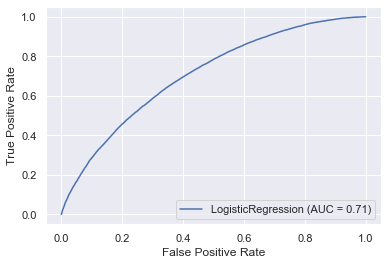

In [96]:
y_pred = gs.predict(X_test)

#fpr, tpr, _ = roc_curve(Y_test,y_pred)
# plt.step(fpr, tpr, color='b', alpha=2, where='post') <-error here
# plt.fill_between(fpr, tpr, alpha=0.2, color='b')

#plt.xlabel('FPR')
#plt.ylabel('TPR')

plot_roc_curve(gs.best_estimator_, X_test, Y_test)

print(f'score: {np.round(roc_auc_score(Y_test, y_pred), 3)}')

plt.show()

In [100]:
# 0.607

------

## Build a random forest model
Use random state 42, maximum depth from 2 to 15, and number of estimators in `[10, 20, 50, 100, 200]`

In [101]:
from sklearn.ensemble import RandomForestClassifier

In [102]:
params = {
    'n_estimators': [10, 20, 50, 100, 200], 
    'max_depth': np.arange(2, 16),
}

rfc = RandomForestClassifier(random_state=42, n_jobs=1)

gs = GridSearchCV(rfc, params, n_jobs=-1, verbose=10)

In [103]:
gs.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.7min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=1,
                                              oob_score=False, random_state=42,
                                  

### Q4.6 What is an optimal depth and number of trees?

In [104]:
gs.best_params_

{'max_depth': 15, 'n_estimators': 200}

In [105]:
#{'max_depth': 15, 'n_estimators': 200}

### Q4.7 What is the accuracy for this params?

In [106]:
np.round(gs.score(X_test, Y_test), 3)

0.689

In [107]:
#0.689

### Q4.8 Build precision-recall curve. What is the precision for recall 0.5?

In [108]:
from sklearn.metrics import precision_recall_curve

Text(0, 0.5, 'recall')

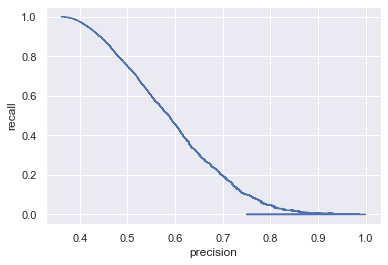

In [109]:
y_prob = gs.predict_proba(X_test)
precision, recall, _ = precision_recall_curve(Y_test, y_prob[:, 1])

plt.plot(precision, recall)

plt.xlabel('precision')
plt.ylabel('recall')

In [110]:
rec_prec = dict(zip(np.round(recall, 3),np.round(precision, 3)))

In [111]:
rec_prec[0.5]

0.587

In [112]:
#0.587

### Q4.9 What is the two most important features by random forest?

------

In [113]:
import operator

In [116]:
sorted(dict(zip(columns, gs.best_estimator_.feature_importances_)).items(), key=operator.itemgetter(1))[-2:]

[('duration_days', 0.1553374118501075), ('goal', 0.30621742992075307)]

In [ ]:
# [('duration_days', 0.1553374118501075), ('goal', 0.30621742992075307)]

------

# Build the stronger model

In [118]:
df= df2.copy()

In [119]:
useless_features = ['deadline', 'launched', 'pledged', 'usd pledged', 'usd_pledged_real', 'backers', 'currency', 'name', 'goal'] 

for col in useless_features:
    df.drop(col, axis=1, inplace=True)

In [120]:
df.head()

,category,main_category,state,country,usd_goal_real,year,duration_days,region,name_length
ID,,,,,,,,,
1000002330,other,Publishing,0,GB,1533.95,2015,58,europe,31
1000003930,other,Film & Video,0,US,30000.00,2017,59,america,45
1000004038,other,Film & Video,0,US,45000.00,2013,44,america,14
1000007540,Music,Music,0,US,5000.00,2012,29,america,49
1000011046,Film & Video,Film & Video,0,US,19500.00,2015,55,america,58


### Q5.1 Generate two (or more) meaningfull features

## avrage goal per region

In [121]:
gp = df.groupby('region')['usd_goal_real'].mean()
df['av_goal_per_reg'] = df['region'].map(gp)

In [122]:
df.head()

,category,main_category,state,country,usd_goal_real,year,duration_days,region,name_length,av_goal_per_reg
ID,,,,,,,,,,
1000002330,other,Publishing,0,GB,1533.95,2015,58,europe,31,56757.454127
1000003930,other,Film & Video,0,US,30000.00,2017,59,america,45,42869.166996
1000004038,other,Film & Video,0,US,45000.00,2013,44,america,14,42869.166996
1000007540,Music,Music,0,US,5000.00,2012,29,america,49,42869.166996
1000011046,Film & Video,Film & Video,0,US,19500.00,2015,55,america,58,42869.166996


## avrage goal per country

In [123]:
gp = df.groupby('country')['usd_goal_real'].mean()
df['av_goal_per_country'] = df['country'].map(gp)

In [124]:
df.head()

,category,main_category,state,country,usd_goal_real,year,duration_days,region,name_length,av_goal_per_reg,av_goal_per_country
ID,,,,,,,,,,,
1000002330,other,Publishing,0,GB,1533.95,2015,58,europe,31,56757.454127,43003.608416
1000003930,other,Film & Video,0,US,30000.00,2017,59,america,45,42869.166996,42959.777881
1000004038,other,Film & Video,0,US,45000.00,2013,44,america,14,42869.166996,42959.777881
1000007540,Music,Music,0,US,5000.00,2012,29,america,49,42869.166996,42959.777881
1000011046,Film & Video,Film & Video,0,US,19500.00,2015,55,america,58,42869.166996,42959.777881


## categorical features processing

In [125]:
one_hot = pd.get_dummies(df['category'],prefix='category')
df = pd.concat([df, one_hot], axis=1).drop(['category'], axis=1)

In [126]:
one_hot = pd.get_dummies(df['main_category'],prefix='main_category')
df = pd.concat([df, one_hot], axis=1).drop(['main_category'], axis=1)

In [127]:
one_hot = pd.get_dummies(df['country'],prefix='country')
df = pd.concat([df, one_hot], axis=1).drop(['country'], axis=1)

In [128]:
one_hot = pd.get_dummies(df['region'],prefix='region')
df = pd.concat([df, one_hot], axis=1).drop(['region'], axis=1)

In [129]:
one_hot = pd.get_dummies(df['year'],prefix='year')
df = pd.concat([df, one_hot], axis=1).drop(['year'], axis=1)

In [130]:
df.head()

,state,usd_goal_real,duration_days,name_length,av_goal_per_reg,av_goal_per_country,category_Accessories,category_Apparel,category_Apps,category_Art,...,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
ID,,,,,,,,,,,,,,,,,,,,,
1000002330,0,1533.95,58,31,56757.454127,43003.608416,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1000003930,0,30000.00,59,45,42869.166996,42959.777881,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1000004038,0,45000.00,44,14,42869.166996,42959.777881,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1000007540,0,5000.00,29,49,42869.166996,42959.777881,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1000011046,0,19500.00,55,58,42869.166996,42959.777881,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Q5.2 Train an xgboost, that's beat random forest

In [131]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [132]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop('state', axis=1), df['state'], test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [133]:
params = {
        'max_depth': [6, 7],
        'n_estimators': [100, 200, 300, 400]
        }

xgb = XGBClassifier(objective='binary:logistic', silent=True, nthread=1)

grid = GridSearchCV(estimator=xgb, param_grid=params, n_jobs=-1, verbose=10)

In [134]:
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.9min remaining: 16.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 10.9min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
       

In [135]:
np.round(grid.score(X_test, Y_test), 3)

0.701

In [136]:
# 0.701

In [137]:
grid.best_params_

{'max_depth': 6, 'n_estimators': 200}

In [138]:
#xgb: {'max_depth': 6, 'n_estimators': 200}

In [139]:
#log reg: 0.6787315650153962

In [140]:
#random forest: 0.6877532278104911

In [141]:
#xgb: 0.701